In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining paths to dataset
train_dir = '/Users/giripragada/Downloads/chest_xray/train'
test_dir = '/Users/giripragada/Downloads/chest_xray/test'
val_dir = '/Users/giripragada/Downloads/chest_xray/val'

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


In [3]:
# Function to load and preprocess images
def load_and_preprocess_images(data_dir, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    data = []
    labels = []
    
    # Loop through the subdirectories (i.e., classes) in the data directory
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            label = 0 if label_dir == 'NORMAL' else 1  # Label 0 for Normal, 1 for Pneumonia
            
            # Loop through each image in the current label directory
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                
                if img is not None:
                    # Resize image to uniform size
                    img_resized = cv2.resize(img, target_size)
                    data.append(img_resized)
                    labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels



In [5]:
# Load training, testing, and validation data
train_data, train_labels = load_and_preprocess_images(train_dir)
test_data, test_labels = load_and_preprocess_images(test_dir)
val_data, val_labels = load_and_preprocess_images(val_dir)

# Normalize pixel values to range [0, 1]
train_data = train_data / 255.0
test_data = test_data / 255.0
val_data = val_data / 255.0


In [7]:

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Reshape data for deep learning
train_data = train_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)  # 3 for RGB channels
test_data = test_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
val_data = val_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        
)

datagen.fit(train_data)




In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

# Model Architecture 
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))  # Very few filters
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))  # Fewer layers and filters
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))  # Small dense layer
model.add(Dropout(0.5))  # dropout rate
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])

model.summary()




/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,605,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,089 (6.13 MB)

 Trainable params: 1,607,089 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=0.000001)



In [13]:
# Training the model
history = model.fit(datagen.flow(train_data, train_labels, batch_size=BATCH_SIZE),
                    epochs=12,
                    validation_data=(val_data, val_labels),
                    callbacks=[learning_rate_reduction])

# Model evaluation
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Loss of the model is: {loss}")
print(f"Accuracy of the model is: {accuracy * 100}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - accuracy: 0.7247 - loss: 0.5823 - val_accuracy: 0.5000 - val_loss: 0.7778 - learning_rate: 0.0100
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.7537 - loss: 0.4994 - val_accuracy: 0.5000 - val_loss: 0.8251 - learning_rate: 0.0100
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.7645 - loss: 0.4484 - val_accuracy: 0.5625 - val_loss: 0.6517 - learning_rate: 0.0100
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.7956 - loss: 0.4149 - val_accuracy: 0.5625 - val_loss: 0.9424 - learning_rate: 0.0100
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.8369 - loss: 0.3540 - val_accuracy: 0.5625 - val_loss: 1.1199 - learning_rate: 0.0100
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.8803 - loss: 0.2888 - val_accuracy: 0.7500 - val_loss: 0.6632 - learning_rate: 0.0030
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - accuracy: 0.8

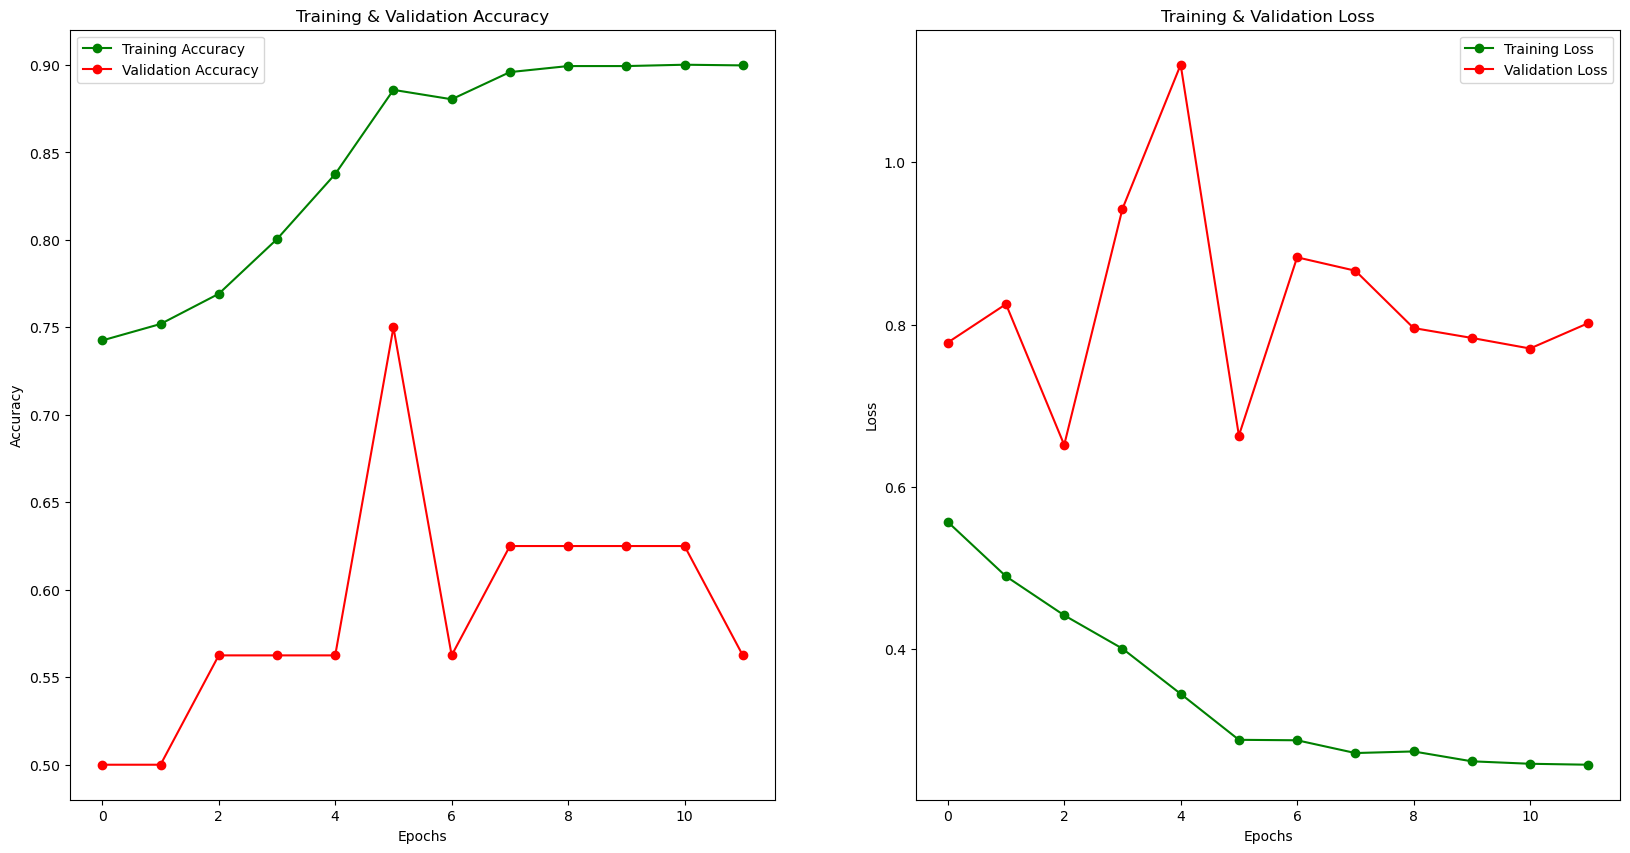

In [15]:
# Plotting training and validation accuracy & loss
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()


In [17]:

# Predictions and classification report
predictions = model.predict(test_data)
predictions = (predictions > 0.5).astype(int)  # Converting probabilities to binary labels

print(classification_report(test_labels, predictions, target_names=['Normal', 'Pneumonia']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

      Normal       0.87      0.57      0.69       234
   Pneumonia       0.79      0.95      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.76      0.77       624
weighted avg       0.82      0.81      0.79       624



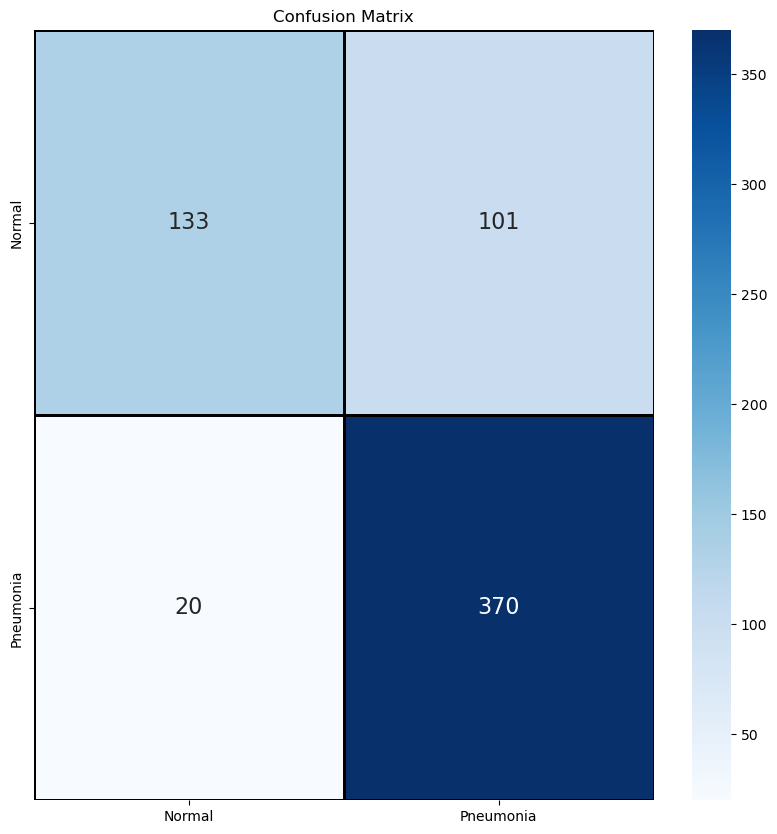

In [19]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index=['Normal', 'Pneumonia'], columns=['Normal', 'Pneumonia'])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Visualize correct predictions
correct = np.nonzero(predictions.flatten() == test_labels)[0]
incorrect = np.nonzero(predictions.flatten() != test_labels)[0]


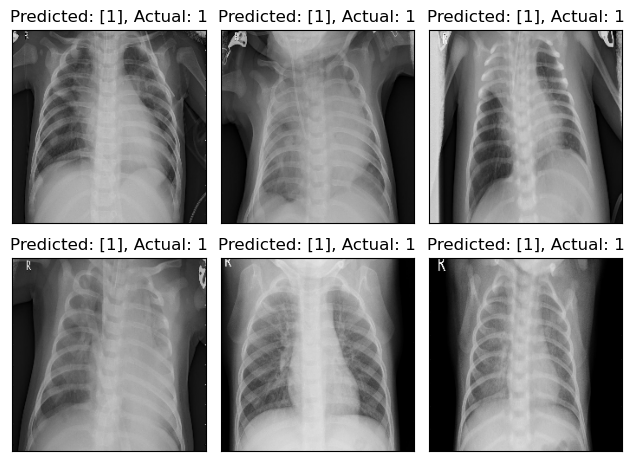

In [23]:
# Show 6 correct predictions
i = 0
for c in correct[:6]:
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[c], cmap="gray")
    plt.title(f"Predicted: {predictions[c]}, Actual: {test_labels[c]}")
    plt.tight_layout()
    i += 1



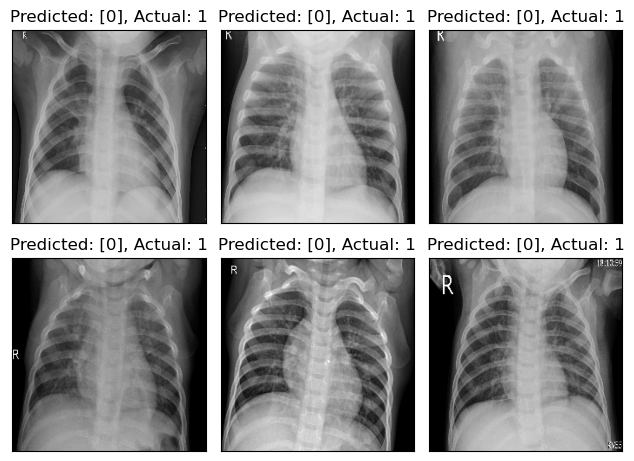

In [25]:
# Show 6 incorrect predictions
i = 0
for c in incorrect[:6]:
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[c], cmap="gray")
    plt.title(f"Predicted: {predictions[c]}, Actual: {test_labels[c]}")
    plt.tight_layout()
    i += 1

plt.show()